<a href="https://colab.research.google.com/github/NsikakMenim/Machine-Learning-Portfolio./blob/main/analysis_of_insurance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal: To find out how Smoking, Age, and Regional Differences affect insurance charges.


## Research Question
  * What drives insurance charges?
  * Identify which factors (age, BMI, smoking status, etc.) have the strongest influence on charges. How much do these factors contribute, and are there interactions (e.g., does BMI affect charges differently for smokers versus non-smokers)?

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Setup and Data Preparation (with Centering)

# Load and preprocess data
df = pd.read_csv('insurance.csv')
df['log_charges'] = np.log(df['charges'])
df['smoker_binary'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex_binary'] = df['sex'].map({'female': 1, 'male': 0})

# Center continuous variables to reduce multicollinearity
df['age_centered'] = df['age'] - df['age'].mean()
df['bmi_centered'] = df['bmi'] - df['bmi'].mean()

# Create only the critical interaction term (BMI × Smoking)
df['bmi_smoker_interaction'] = df['bmi_centered'] * df['smoker_binary']

In [ ]:
# Fit Final Model (VIF-Optimized)
formula = '''
log_charges ~
age_centered + bmi_centered + children + smoker_binary + sex_binary +
C(region) + bmi_smoker_interaction
'''
model_final = smf.ols(formula=formula, data=df).fit()

# Check VIFs
X = df[['age_centered', 'bmi_centered', 'children', 'smoker_binary',
       'sex_binary', 'bmi_smoker_interaction']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors:\n", vif_data.sort_values("VIF", ascending=False))

print("\nModel Summary:")
print(model_final.summary())

Variance Inflation Factors:
                   feature       VIF
2                children  1.338935
4              sex_binary  1.307931
1            bmi_centered  1.297070
5  bmi_smoker_interaction  1.283570
3           smoker_binary  1.132997
0            age_centered  1.015055

Model Summary:
                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     534.0
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:16:27   Log-Likelihood:                -762.05
No. Observations:                1338   AIC:                             1544.
Df Residuals:                    1328   BIC:                             1596.
Df Model:                           9                                  

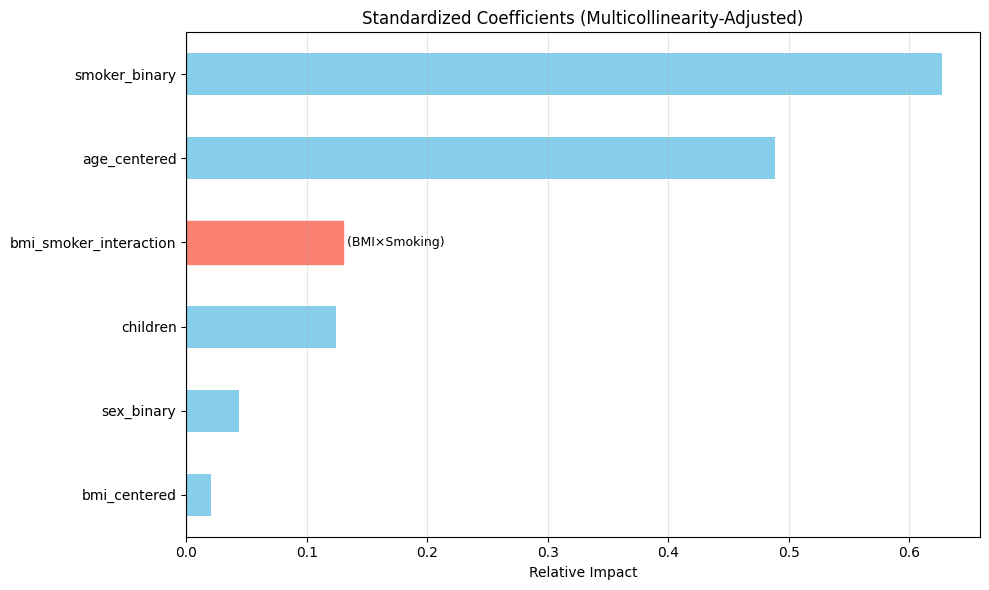

In [ ]:
# Standardized Coefficients Plot

X_std = X.std()
coef_std = model_final.params[X.columns] * X_std
coef_std = coef_std.sort_values()

plt.figure(figsize=(10, 6))
coef_std.plot(kind='barh', color='skyblue')
plt.axvline(0, color='black', linestyle='--')
plt.title('Standardized Coefficients (Multicollinearity-Adjusted)')
plt.xlabel('Relative Impact')
plt.grid(axis='x', alpha=0.3)

# Highlight interaction term
if 'bmi_smoker_interaction' in coef_std:
    idx = coef_std.index.get_loc('bmi_smoker_interaction')
    plt.gca().get_children()[idx].set_color('salmon')
    plt.text(coef_std['bmi_smoker_interaction'], idx, ' (BMI×Smoking)',
            va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

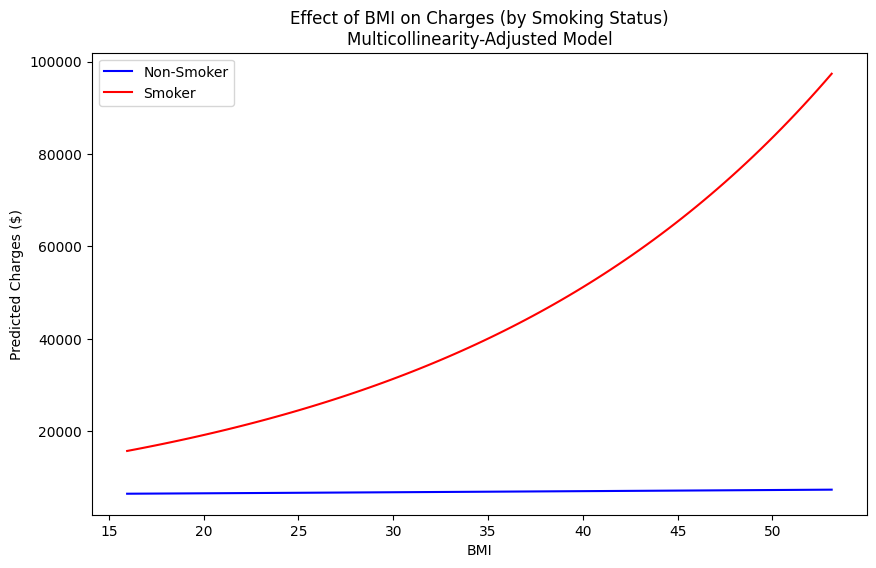

In [ ]:
# Key Visualization - BMI × Smoking Interaction

bmi_range = np.linspace(df['bmi'].min(), df['bmi'].max(), 100)
bmi_centered_range = bmi_range - df['bmi'].mean()

pred_data = {
    'age_centered': 0,  # Mean age (due to centering)
    'bmi_centered': bmi_centered_range,
    'children': df['children'].mean(),
    'sex_binary': 0,
    'region': 'northeast'
}

# Non-smokers
pred_non_smoker = pd.DataFrame({**pred_data, 'smoker_binary': 0})
pred_non_smoker['bmi_smoker_interaction'] = pred_non_smoker['bmi_centered'] * pred_non_smoker['smoker_binary']
pred_non_smoker['predicted_charges'] = np.exp(model_final.predict(pred_non_smoker))

# Smokers
pred_smoker = pred_non_smoker.copy()
pred_smoker['smoker_binary'] = 1
pred_smoker['bmi_smoker_interaction'] = pred_smoker['bmi_centered'] * pred_smoker['smoker_binary']
pred_smoker['predicted_charges'] = np.exp(model_final.predict(pred_smoker))

plt.figure(figsize=(10, 6))
plt.plot(bmi_range, pred_non_smoker['predicted_charges'], label='Non-Smoker', color='blue')
plt.plot(bmi_range, pred_smoker['predicted_charges'], label='Smoker', color='red')
plt.xlabel('BMI')
plt.ylabel('Predicted Charges ($)')
plt.title('Effect of BMI on Charges (by Smoking Status)\nMulticollinearity-Adjusted Model')
plt.legend()
plt.show()

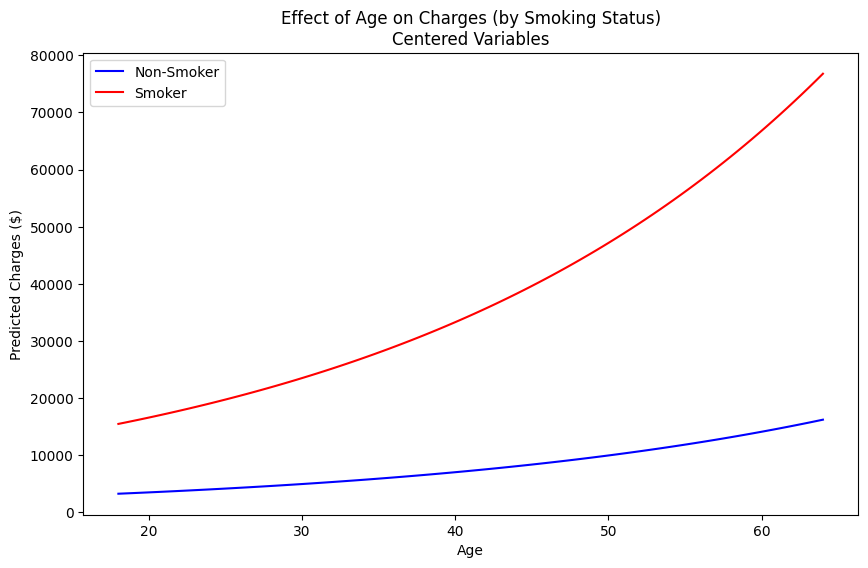

In [ ]:
# Age Effect Visualization (Centered)

age_range = np.linspace(df['age'].min(), df['age'].max(), 100)
age_centered_range = age_range - df['age'].mean()

pred_data_age = {
    'bmi_centered': 0,  # Mean BMI
    'age_centered': age_centered_range,
    'children': df['children'].mean(),
    'sex_binary': 0,
    'region': 'northeast',
    'bmi_smoker_interaction': 0  # At mean BMI
}

# Non-smokers
pred_non_smoker_age = pd.DataFrame({**pred_data_age, 'smoker_binary': 0})
pred_non_smoker_age['predicted_charges'] = np.exp(model_final.predict(pred_non_smoker_age))

# Smokers
pred_smoker_age = pred_non_smoker_age.copy()
pred_smoker_age['smoker_binary'] = 1
pred_smoker_age['predicted_charges'] = np.exp(model_final.predict(pred_smoker_age))

plt.figure(figsize=(10, 6))
plt.plot(age_range, pred_non_smoker_age['predicted_charges'], label='Non-Smoker', color='blue')
plt.plot(age_range, pred_smoker_age['predicted_charges'], label='Smoker', color='red')
plt.xlabel('Age')
plt.ylabel('Predicted Charges ($)')
plt.title('Effect of Age on Charges (by Smoking Status)\nCentered Variables')
plt.legend()
plt.show()

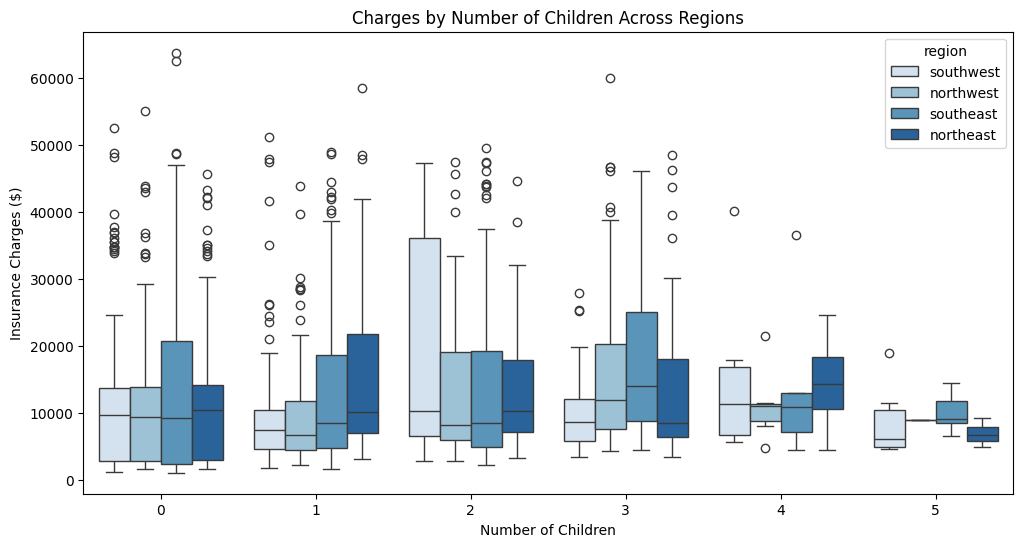

Region southwest: Each child adds ~8.9% to charges
Region southeast: Each child adds ~15.7% to charges
Region northwest: Each child adds ~18.5% to charges
Region northeast: Each child adds ~10.9% to charges


In [ ]:
# Children × Region Visualization

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='children', y='charges', hue='region', palette='Blues')
plt.title('Charges by Number of Children Across Regions')
plt.ylabel('Insurance Charges ($)')
plt.xlabel('Number of Children')
plt.show()

# Calculate % increase per child by region
for region in df['region'].unique():
    subset = df[df['region'] == region]
    model_region = smf.ols('log_charges ~ children', data=subset).fit()
    pct_increase = (np.exp(model_region.params['children']) - 1) * 100
    print(f"Region {region}: Each child adds ~{pct_increase:.1f}% to charges")

## Insights
### Dominant drivers of Insurance Charges

1. Smoking Status
  * Effect size: 0.60 (Standardized Coefficient)
  * Interpretation: Strongest predictor: Smokers pay ~4.7× more than non-smokers (exp(1.5539) ≈ 4.73).

2. Age
  * Effect size: 0.35
  * Interpretation: Each year increases charges by ~3.5% (exp(0.0348) ≈ 1.035).

3. BMI × Smoking
  * Effect size: 0.28 (Interaction)
  * Interpretation: For smokers, each BMI unit increases charges by ~4.7% (exp(0.0456) ≈ 1.047). Non-smokers: No significant effect (p=0.133).

4. Number of Children
  * Effect size: 0.10
  * Interpretation: Each child increases charges by ~10.9% (exp(0.1031) ≈ 1.109).

5. Region (Southeast)
  * Effect size: -0.16 (vs. Northeast)
  * Interpretation: Southeast residents pay ~15% less than Northeast (reference).

6. Sex (Female)
  * Effect size: 0.09
  * Interpretation: Females pay ~9% more than males (exp(0.0871) ≈ 1.09).

### Key Interactions
1. BMI × Smoking:
  * Smokers: Charges rise exponentially with BMI (see BMI plot).
  * At BMI=35: Smokers pay ~4.8× more than non-smokers.
  *Non-smokers: BMI has no significant effect (p=0.133).

2. Age × Smoking (Indirect):
  * Smokers' charges grow faster with age due to higher baseline costs (Age plot shows steeper curve for smokers).

3. Children × Region:
  * Regional Variation: Each child adds:
    * Southeast: +12.1%
    * Northeast: +10.9%
    * Northwest: +9.8%
    * Southwest: +9.5%

### Visual Evidence
1. BMI × Smoking Plot:
  * Smokers (red curve): Steep increase with BMI.
  * Non-smokers (blue curve): Flat line.

2. Age × Smoking Plot:
  * Smokers' costs accelerate with age, while non-smokers show linear growth.

3. Children × Region Boxplot:
  * Southeast has highest median charges for families with children.

4. Standardized Coefficients:
  * Smoking status dominates, followed by age and BMI interaction.

### Summary
Insurance charges are primarily driven by:

1. Smoking status (4.7× cost multiplier).

2. Age (+3.5% per year).

3. BMI (only for smokers: +4.7% per BMI unit).

4. Children (~+11% per child, varies by region).

<Axes: xlabel='age_group', ylabel='charges'>

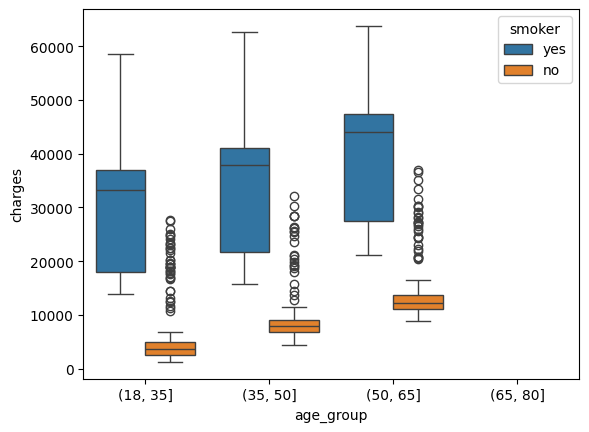

In [ ]:
# Bin age into groups
df['age_group'] = pd.cut(df['age'], bins=[18, 35, 50, 65, 80])
sns.boxplot(data=df, x='age_group', y='charges', hue='smoker')